# HW2 - Bayesian Inference in the Poisson Generalized Linear Model

**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Isaac Kleisle-Murphy

**Names of any collaborators:** Yan, Anmol

*Due: 11:59pm Friday, April 16, 2021 via GradeScope*

---

In this 2nd homework, we will perform Bayesian Inference in the Poisson generalized linear model.

**References:**
- Chapter 16 of BDA3 contains background material on generalized linear models.
- Chapter 7.1 of BDA3 introduces notation for model evaluation based on predictive log likelihoods.
- The data we use comes from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long). If you're interested, see `README.txt` file in the `/data_RGCs` directory or the [Pillow  tutorial](https://github.com/pillowlab/GLMspiketraintutorial/blob/master/python/tutorial1_PoissonGLM.ipynb) for details.


**Remark:** While some programming languages may incorporate packages that fit Poisson GLMs using one line of code, deriving some of the calculations yourself is an important part of this assignment. Therefore, calls to specialized GLM libraries such as pyglmnet are **prohibited**. Of course, standard libraries such as Numpy are still allowed (and encouraged!). calls to numerical optimizers (such as scipy.optimize.minimize) are fair game. 



## The Poisson GLM
The Poisson distribution is a common model for count data with a single parameter $\lambda \in \mathbb{R}_+$. Its pmf is,
\begin{align}
\Pr(y \mid \lambda) &= \frac{1}{y!} e^{-\lambda} \lambda^y,
\end{align}
for $y \in \mathbb{N}$. Its mean and variance are both equal to $\lambda$.

Suppose we have count observations $y_n \in \mathbb{N}$ along with covariates $x_n \in \mathbb{R}^P$. We construct a Poisson GLM by modeling the expected value as,
\begin{align}
\mathbb{E}[y_n \mid x_n] = f(w^\top x_n),
\end{align}
with $w \in \mathbb{R}^P$ and $f: \mathbb{R} \to \mathbb{R}_+$ is the mean function. The _canonical mean function_ is $f(a) = e^a$; equivalently, the canonical _link_ function is the logarithm.


We assume a Gaussian prior on the weights $w$:
$$
w \sim \mathcal{N}(0, \sigma^2 I),
$$

where $\sigma^2 I$ is the covariance matrix.


## Load the data

The data consists of spike counts from a retinal neuron responding to a flickering light. The spike counts are measured in 8.3ms bins and they range from 0 to 3 spikes/bin. The stimulus is binary, either .48 if the light is on or -.48 if it's off. The goal of this assignment is to model how the neural spike counts relate to recent light exposure over the past 25 time bins (approximately 200ms).

We've provided some code to load the data in Python and plot it. Feel free to convert this to R if that is your preference.

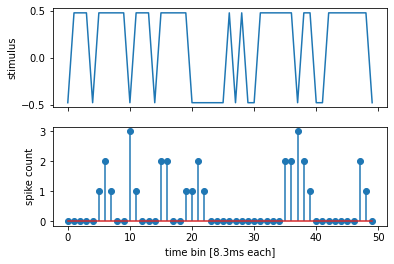

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import hankel
from scipy.stats import multivariate_normal, norm, poisson

df = pd.read_csv("hw2.csv")

# Convert the training data to arrays
y_train = np.array(df["y_train"])
stim_train = np.array(df["stim_train"])
N_train = len(y_train)

# Convert the test data to arrays
y_test = np.array(df["y_test"])
stim_test = np.array(df["stim_test"])
N_test = len(y_test)

# Plot the stimulus and spike counts
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(stim_train[:50])
axs[0].set_ylabel("stimulus")
axs[1].stem(y_train[:50], use_line_collection=True)
axs[1].set_ylabel('spike count')
_ = axs[1].set_xlabel('time bin [8.3ms each]')

In [2]:
# a quick look at the dataframe
df

,Unnamed: 0,y_train,stim_train,y_test,stim_test
0,1,0,-0.48,0,-0.48
1,2,0,0.48,0,-0.48
2,3,0,0.48,0,0.48
3,4,0,0.48,0,0.48
4,5,0,-0.48,0,0.48
...,...,...,...,...,...
995,996,2,0.48,2,-0.48
996,997,2,-0.48,0,0.48
997,998,2,-0.48,0,0.48
998,999,0,0.48,1,-0.48


## Problem 1: Construct the design matrix

Let $y_n \in \mathbb{N}$ denote the spike count in the $n$-th time bin and  $s_n \in \mathbb{R}$ denote the corresponding stimulus at that bin.

Construct the _design matrix_ for the training data $X \in \mathbb{R}^{N_{\mathsf{train}} \times P}$ with rows
\begin{align}
x_n &= (1, s_n, s_{n-1}, \ldots, s_{n-L+1})
\end{align}
where $L=25$ denotes the number of stimulus bins to include in the covariates. (Thus the number of total covariates is $P=L+1$.)

Visualize the first 50 rows of the matrix with, e.g., `imshow`. Don't forget your labels and colorbar.

_Note: Pad the stimulus with zeros so that $s_i = 0$ for $i\leq 0$._

In [3]:
def construct_design(x, padlength=25):
    """
    Constructs a design matrix, as instructed by the problem. Uses section 3b of 
    attached tutorial, so most recent is on the RHS, least recent on the LHS. 

    Args:
       x : list, np.array, pd.Series
           An array-like of stimuli to pad
       padlength : int
           pad size
    Returns : np.array[len(x), padlength + 1]
       The padded array
    """
    x_padded = np.hstack((np.zeros(padlength-1), x))
    x_design = hankel(x_padded[:-padlength+1], x[-padlength:])[:, ::-1]
    x_design = np.hstack([np.ones(len(x)).reshape(-1, 1), x_design])
    return x_design

y_train = df['y_train'].values
x_train = construct_design(df['stim_train'].values, padlength=25)
x_train

array([[ 1.  , -0.48,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.48, -0.48, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.48,  0.48, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.  , -0.48, -0.48, ..., -0.48,  0.48,  0.48],
       [ 1.  ,  0.48, -0.48, ..., -0.48, -0.48,  0.48],
       [ 1.  ,  0.48,  0.48, ..., -0.48, -0.48, -0.48]])

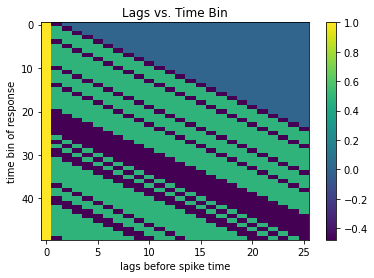

In [4]:
plt.clf() 
plt.imshow(x_train[:50], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.title('Lags vs. Time Bin')
plt.colorbar()
plt.show()

## Problem 2a [Math]: Derive the log joint probability
Derive the log joint probability, 
\begin{align}
\mathcal{L}(w) &\triangleq \log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2) \\
&= \ldots
\end{align}

First, it may be useful to derive certain properties of the Poisson GLM, and build up to the log joint probability. For a single observation $i$, we have
\begin{align*}
p(y_i; \lambda) 
&= \frac{e^{-\lambda}\lambda^{y_i}}{y_i!} \\
&= \frac{1}{y!} \exp(y_i\log(\lambda) - \lambda).
\end{align*}
Under this rearrangment, it is clear from a GLM perspective that

- $b(y) = \frac{1}{y!}$

- $T(y) = y$

- $\eta_i = \log(\lambda) \implies \lambda = \exp(\eta_i)$

- $\alpha(\eta_i) = \lambda = \exp(\eta_i)$

Per usual, we will model $\eta_i = w^Tx_i$, which we will substitute in in short order.

Now consider the joint likelihood. We have:

\begin{align*}
L(w; x, y) &= 
\bigg(\prod_{i=1}^n \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}\bigg)\pi(w) \\
&= 
\bigg(\prod_{i=1}^n \frac{e^{\eta_i y_i - e^\eta_i}}{y_i!}\bigg)\pi(w) \\
\ell (w; x, y) &=
\bigg(\sum_{i=1}^n \eta_i y_i - e^\eta_i - log({y_i!})\bigg) + \log(\pi(w)) \\
&=
\bigg(\sum_{i=1}^n w^Tx_i y_i - e^{w^Tx_i} - log({y_i!})\bigg) - \frac{1}{2\sigma^2}w^Tw - 
\frac{P}{2}\log(2\pi) - \frac{1}{2}\log|\sigma^2 I|
\end{align*}



## Problem 2b [Code]: Implement the log probability function
Write a function that computes the log joint probability and evaluate it on the training set with $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. **Print your result.**

In [5]:
def compute_log_prob(y, x, w, w_prior=np.zeros(26), sigma2=1):
    """
    Computes log density.
    Args:
        y : np.array[n, ] 
            The target data
        x : np.array[n, p]
            the feature matrix
        w : np.array[p, ]
            GLM coefficients (with intercept)
    """
    prior_lik = multivariate_normal.logpdf(w, w_prior, sigma2 * np.eye(len(w)))
    glm_lik = np.sum(poisson.logpmf(y, np.exp(x.dot(w))))
    return prior_lik + glm_lik

compute_log_prob(y=y_train, x=x_train, w=np.zeros(26), w_prior=np.zeros(26), sigma2=1)

-1125.7464724378729

## Problem 3a [Math]: Derive the gradient
Derive the gradient of the log joint probability
\begin{align}
\nabla_w \mathcal{L}(w) &= \ldots
\end{align}
*Show your work*.


Next, we compute the gradient, using the chain rule early/often:
\begin{align*}
\nabla_w \ell (w; x, y)
&=
\nabla_w \bigg(\bigg(\sum_{i=1}^n w^Tx_i y_i - e^{w^Tx_i} - log({y_i!})\bigg) - \frac{1}{2\sigma^2}w^Tw - 
\frac{P}{2}\log(2\pi) - \frac{1}{2}\log|\sigma^2 I|\bigg) \\
&=
\bigg(\sum_{i=1}^n x_i y_i - e^{w^Tx_i}x_i)\bigg) - w/\sigma^2 \\
&=
\bigg(\sum_{i=1}^n (y_i - e^{w^Tx_i})x_i)\bigg) - w/\sigma^2.
\end{align*}


## Problem 3b [Code]: Implement the gradient

Write a function to compute the gradient wrt $w$ of the log probability for given values of $w$ and evaluate it on the training set at $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. **Print your result.**

**Note:**  While this is not required in this homework, it may be helpful to do numerical checks for gradient and Hessian calculations using finite differences.  See *e.g.* Section 4.2 of https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf.

In [6]:
def compute_gradient(y, x, w, sigma2=1):
    eta = x.dot(w)
    grad = np.vstack([(y[i] - np.exp(eta[i])) * x[i, ] 
                      for i in range(len(y))]).sum(axis=0) - w/sigma2
#     yhat = np.exp(x.dot(w))
#     grad = (y - yhat).T.dot(x) - w
    return grad
compute_gradient(y=y_train, x=x_train, w=np.zeros(x_train.shape[1]))

array([-603.  ,    7.2 ,   18.24,   44.64,  119.04,  145.44,   64.32,
        -51.84,  -59.04,  -44.64,  -44.16,  -47.52,  -54.24,  -33.12,
        -27.84,  -50.4 ,  -48.  ,  -34.08,  -50.88,  -38.88,  -22.08,
        -37.44,  -29.76,  -11.04,    2.4 ,    1.92])

## Problem 4a [Math]: Derive the Hessian
Derive the Hessian of the log joint probability
\begin{align}
\nabla^2_w \mathcal{L}(w) &= \ldots
\end{align}
*Show your work*.


Here, we tackle the Hessian. We begin by picking up where we left off at the gradient (just one more chain rule):
\begin{align*}
\nabla^2_w \ell (w; x, y)
&=
\nabla_w \bigg[\bigg(\sum_{i=1}^n (y_i - e^{w^Tx_i})x_i)\bigg) - w/\sigma^2\bigg] \\
&=
-\bigg(\sum_{i=1}^n e^{w^Tx_i}x_ix_i^T\bigg) - \sigma^2I \\
&=
-X\lambda X - \sigma^2I,
\end{align*}
where $\lambda$ is a $n \times n$ diagonal matrix s.t.
$$
\lambda_i = \exp(w^Tx_i),
$$
via our familiar link function. 


## Problem 4b [Code]: Implement the Hessian

Write a function to compute the Hessian of the log probability for given values of $w$ and $\sigma^2$ and evaluate it on the training set at $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. 

Visualize the Hessian with, e.g., `imshow`. Don't forget labels and a colorbar.

We plot both the Hessian, and the inverse Hessian. Note here that when we say "lag index", we're describing the index of the features that are lags. Of course, the 0th lag index is simply the intercept, to avoid confusion here.

In [7]:
def compute_hessian(w, x, sigma2=1):
    """"""
    V = np.diag(np.exp(x.dot(w)))
    H = -(x.T.dot(V).dot(x) + np.eye(x.shape[1])/sigma2)
    return H

hess_p4 = compute_hessian(w=np.zeros(x_train.shape[1]), x=x_train)
pd.DataFrame(hess_p4)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-1001.00,-13.4400,-12.9600,-12.4800,-12.9600,-13.4400,-12.9600,-12.4800,-12.0000,-11.5200,...,-12.9600,-13.4400,-12.9600,-12.4800,-12.9600,-13.4400,-13.9200,-14.4000,-14.8800,-15.3600
1,-13.44,-231.4000,-2.9952,-11.9808,-0.2304,-18.8928,1.1520,1.3824,-2.9952,-23.0400,...,10.3680,4.6080,23.2704,4.1472,11.2896,-3.6864,-4.3776,-4.1472,0.6912,-6.4512
2,-12.96,-2.9952,-231.1696,-2.7648,-12.2112,-0.4608,-18.6624,1.3824,1.6128,-2.7648,...,19.1232,10.1376,4.8384,23.5008,3.9168,11.0592,-3.9168,-4.6080,-4.3776,0.4608
3,-12.48,-11.9808,-2.7648,-230.9392,-2.9952,-12.4416,-0.2304,-18.4320,1.6128,1.8432,...,13.5936,18.8928,10.3680,5.0688,23.2704,3.6864,10.8288,-4.1472,-4.8384,-4.6080
4,-12.96,-0.2304,-12.2112,-2.9952,-230.7088,-2.7648,-12.6720,-0.4608,-18.6624,1.3824,...,3.9168,13.8240,18.6624,10.1376,5.2992,23.5008,3.9168,11.0592,-3.9168,-4.6080
5,-13.44,-18.8928,-0.4608,-12.4416,-2.7648,-230.4784,-2.9952,-12.9024,-0.6912,-18.8928,...,-6.6816,4.1472,13.5936,18.4320,10.3680,5.5296,23.7312,4.1472,11.2896,-3.6864
6,-12.96,1.1520,-18.6624,-0.2304,-12.6720,-2.9952,-230.2480,-2.7648,-12.6720,-0.4608,...,-1.6128,-6.9120,4.3776,13.8240,18.2016,10.1376,5.2992,23.5008,3.9168,11.0592
7,-12.48,1.3824,1.3824,-18.4320,-0.4608,-12.9024,-2.7648,-230.0176,-2.5344,-12.4416,...,6.6816,-1.8432,-6.6816,4.6080,13.5936,17.9712,9.9072,5.0688,23.2704,3.6864
8,-12.00,-2.9952,1.6128,1.6128,-18.6624,-0.6912,-12.6720,-2.5344,-229.7872,-2.3040,...,-22.8096,6.4512,-1.6128,-6.4512,4.3776,13.3632,17.7408,9.6768,4.8384,23.0400
9,-11.52,-23.0400,-2.7648,1.8432,1.3824,-18.8928,-0.4608,-12.4416,-2.3040,-229.5568,...,-2.5344,-23.0400,6.6816,-1.3824,-6.6816,4.1472,13.1328,17.5104,9.4464,4.6080


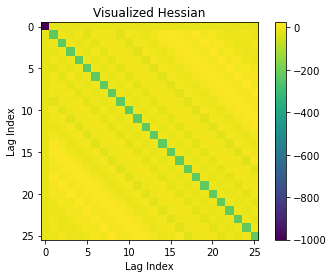

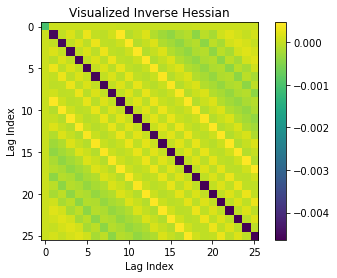

In [8]:
plt.clf()
plt.imshow(hess_p4)
plt.xlabel('Lag Index')
plt.ylabel('Lag Index')
plt.title('Visualized Hessian')
plt.colorbar()
plt.show()


plt.clf()
plt.imshow(np.linalg.inv(hess_p4))
plt.xlabel('Lag Index')
plt.ylabel('Lag Index')
plt.title('Visualized Inverse Hessian')
plt.colorbar()
plt.show()

## Problem 5

## Problem 5a: Optimize to find the posterior mode
Optimize the log joint probability to find the posterior mode. You may use built-in optimization libraries (e.g. `scipy.optimize.minimize`).

## Problem 5b: Approximate the covariance at the mode

Solve for $\Sigma_{\mathsf{MAP}} = -[\nabla^2(\mathcal{L}(w_{\mathsf{MAP}})]^{-1}$. Plot the covariance matrix (e.g. with `imshow`). Don't forget to add a colorbar and labels.

In [9]:
def newton(y, 
           x, 
           w_init=None, 
           gamma=1e-1, 
           tol=1e-5, 
           maxiter=1e5, 
           gradient=compute_gradient, 
           hessian=compute_hessian):
    """
    Ya cowboy
    
    Args:
        y : np.array[n]
            An array of targets
        x : np.array[n, p]
            The design matrix
        w_init : np.array(p) or None
            An optional array of initial weights
        gamma : float
            Learning rate
        tol : float
            When the l2 norm between w_{t+1} and w_t dips below this value,
            the model is said to have converged
        maxiter : int
            Maximum iterations to peform before stopping, with a warning
        gradient : callable
            A function to calculate the gradient w.r.t. y, x, w
        hessian : callable
            A function to calculate the Hessian w.r.t. y, x, w
    Returns : tuple[np.array[p], np.array[n_iter, p]]
        A tuple containing:
            - the weights at last iteration
            - a matrix of weights over all iterations
    """
    w_init = np.zeros(x.shape[1]) if w_init is None else w_init
    eps = 1e10 # l2 norm of difference between iterations
    wold = w_init # starting value for w
    n_iter = 1 # counter
    w_log = [wold] # for tracking
    eps_log = [] # for tracking

    while eps > tol and n_iter <= maxiter:
        grad = gradient(y=y, x=x, w=wold)
        H = hessian(w=wold, x=x_train)
        wnew = wold - gamma * (np.linalg.inv(H)).dot(grad)
        eps = np.linalg.norm(wnew - wold, ord=2)
        # logging
        eps_log.append(eps)
        w_log.append(wnew)
        # advancing
        wold = wnew
        n_iter += 1
    w_log = np.vstack(w_log)

    if n_iter >= maxiter:
        warnings.warn('Solver failed to converge')
    return wnew, w_log

w_map, w_map_log = newton(
    y_train, 
    x_train, 
    gamma=1e-1, 
    tol=1e-6, 
    maxiter=1e5)
cov_wmap = - np.linalg.inv(compute_hessian(w_map, x_train))
pd.DataFrame(cov_wmap)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.010385,-0.000234,-0.000613,-0.001231,-0.005843,-0.012001,-0.002162,0.001329,0.000981,0.001090,...,0.000070,0.000229,0.000351,0.000137,-0.000602,-0.000201,-0.000603,0.000259,0.000084,0.000037
1,-0.000234,0.011771,-0.000392,-0.000201,-0.000359,-0.000673,0.000501,-0.000886,0.000209,-0.002132,...,0.000981,-0.000246,0.000966,0.000954,0.001048,-0.000422,-0.000590,0.000059,0.000307,0.000534
2,-0.000613,-0.000392,0.011855,0.000070,-0.000452,0.000212,-0.000867,0.000420,-0.000381,-0.000173,...,0.000429,0.001144,-0.000373,0.000910,0.001115,0.000853,-0.000510,-0.000464,-0.000581,-0.000134
3,-0.001231,-0.000201,0.000070,0.012623,-0.000784,-0.000429,0.000617,-0.000999,-0.000087,-0.000329,...,0.001122,0.000534,-0.000026,0.000488,0.001032,0.000801,0.000571,-0.001019,-0.001220,-0.000502
4,-0.005843,-0.000359,-0.000452,-0.000784,0.020632,-0.000918,-0.000821,0.000821,-0.000658,-0.000154,...,-0.000037,0.000891,0.000682,-0.000413,0.000907,0.001474,0.000006,-0.000015,0.000011,-0.001007
5,-0.012001,-0.000673,0.000212,-0.000429,-0.000918,0.032763,-0.000956,-0.000650,0.000641,-0.000833,...,-0.000065,0.000038,0.000820,0.000640,-0.000203,0.000714,0.001841,-0.001027,0.000103,-0.000300
6,-0.002162,0.000501,-0.000867,0.000617,-0.000821,-0.000956,0.014528,-0.001060,-0.000252,0.000437,...,0.001734,-0.000795,-0.000115,0.000623,0.000871,-0.000707,0.001169,0.001896,-0.001430,0.000322
7,0.001329,-0.000886,0.000420,-0.000999,0.000821,-0.000650,-0.001060,0.013055,-0.000515,0.000222,...,-0.000135,0.001296,-0.000623,-0.000017,0.000003,0.001346,-0.000390,0.001563,0.001822,-0.001095
8,0.000981,0.000209,-0.000381,-0.000087,-0.000658,0.000641,-0.000252,-0.000515,0.012931,-0.000060,...,-0.001996,0.000505,-0.000402,-0.000506,-0.000435,-0.000033,0.001788,0.000395,0.000884,0.001989
9,0.001090,-0.002132,-0.000173,-0.000329,-0.000154,-0.000833,0.000437,0.000222,-0.000060,0.012953,...,-0.000824,-0.001708,0.000522,-0.001025,-0.000816,-0.000680,-0.000123,0.002491,0.000401,0.000262


Again, bear in mind the 0th index is just for the intercept. 

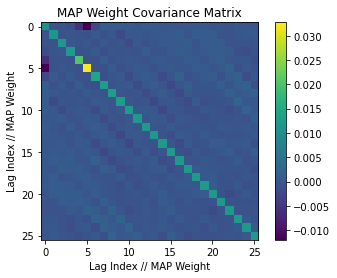

In [10]:
plt.clf()
plt.imshow(cov_wmap)
plt.xlabel('Lag Index // MAP Weight')
plt.ylabel('Lag Index // MAP Weight')
plt.title('MAP Weight Covariance Matrix')
plt.colorbar()
plt.show()

## Problem 6: Plot the posterior of the weights
Plot the posterior mean of the weights for features $s_n, \ldots, s_{n-L+1}$ (i.e. not including the bias term). Also plot 95% credible intervals around the mean by using two standard deviations of the marginal distribution of the weights. Note the diagonal of $\Sigma_{\mathsf{MAP}}$ gives the marginal variance of the posterior. 

First, I present the posterior weights as is. Second, I plot a density for each of them. Third, I plot them w.r.t. their lag index, to see which of the previous time windows may be most important. 

In [11]:
w_map

array([-1.98387467,  0.01916078,  0.13772364,  0.44424144,  1.54387934,
        2.25596082,  0.73980371, -0.53345703, -0.52034956, -0.45324512,
       -0.41421336, -0.24945054, -0.4764015 , -0.32471314, -0.14218603,
       -0.26219321, -0.19492622, -0.06752119, -0.13640114, -0.02965932,
        0.13819359, -0.06414585,  0.03259843, -0.01427306, -0.01652936,
       -0.0532132 ])

<Figure size 2000x2000 with 0 Axes>

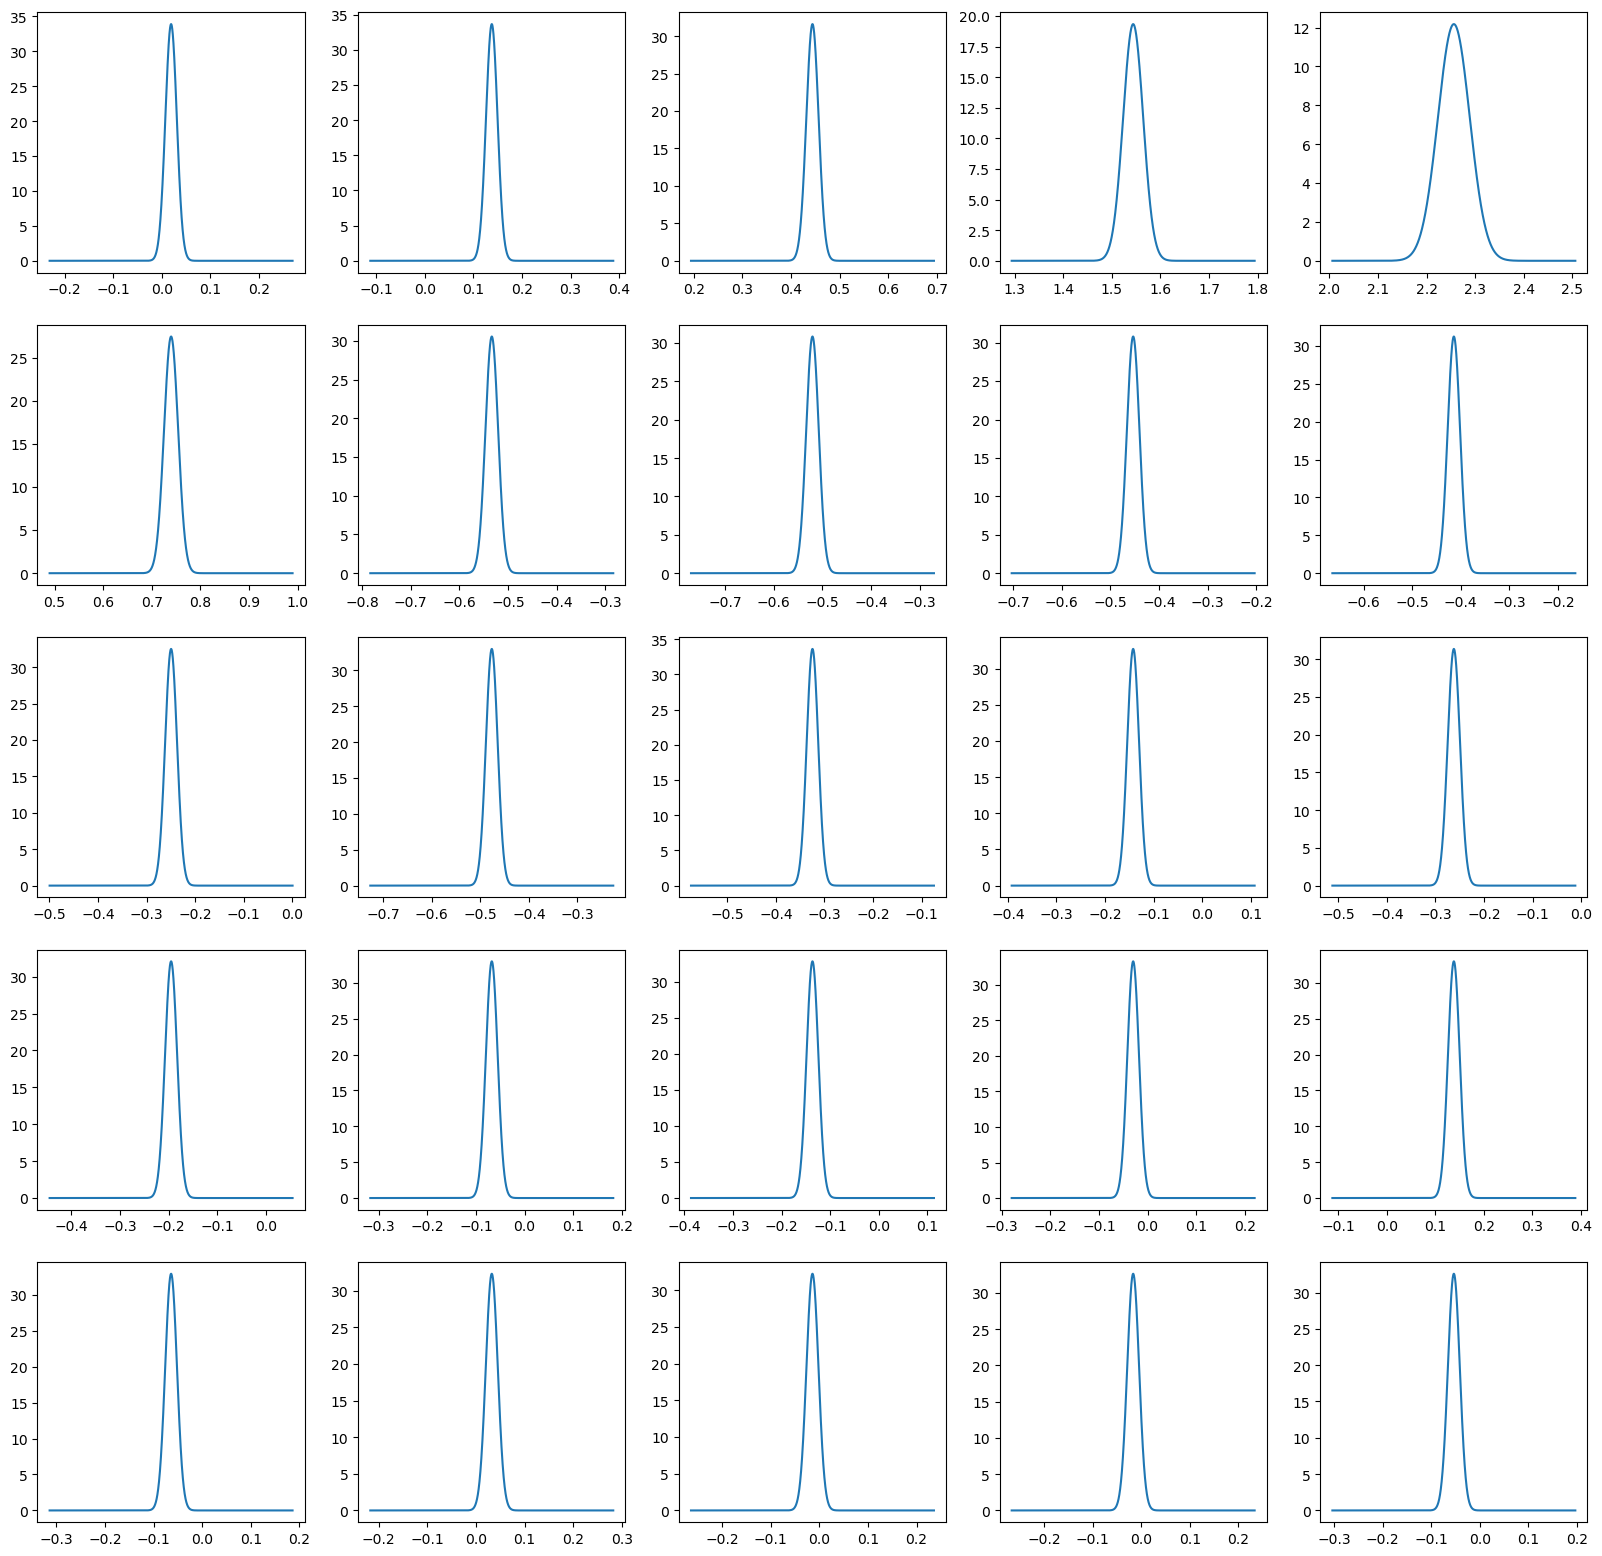

<Figure size 100000x100000 with 0 Axes>

In [12]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.dpi'] = 100
plt.clf()
fig, axs = plt.subplots(5, 5)
row, col = 0, 0
for i in range(1, 26):
    x_ = np.zeros(len(w_map)); x_[i] = 1 # for marginalizing
    marginal_cov = x_.T.dot(cov_wmap).dot(x_) # marginal covariance
    x_sup = np.linspace(w_map[i] - .25, w_map[i] + .25, 10000)
    posterior_density = norm.pdf(x_sup, w_map[i], marginal_cov)
    axs[row, col].plot(x_sup, posterior_density)
    col += 1
    if col > 4:
        row += 1
        col = 0
plt.figure(figsize=(1000, 1000))
plt.show()

[]

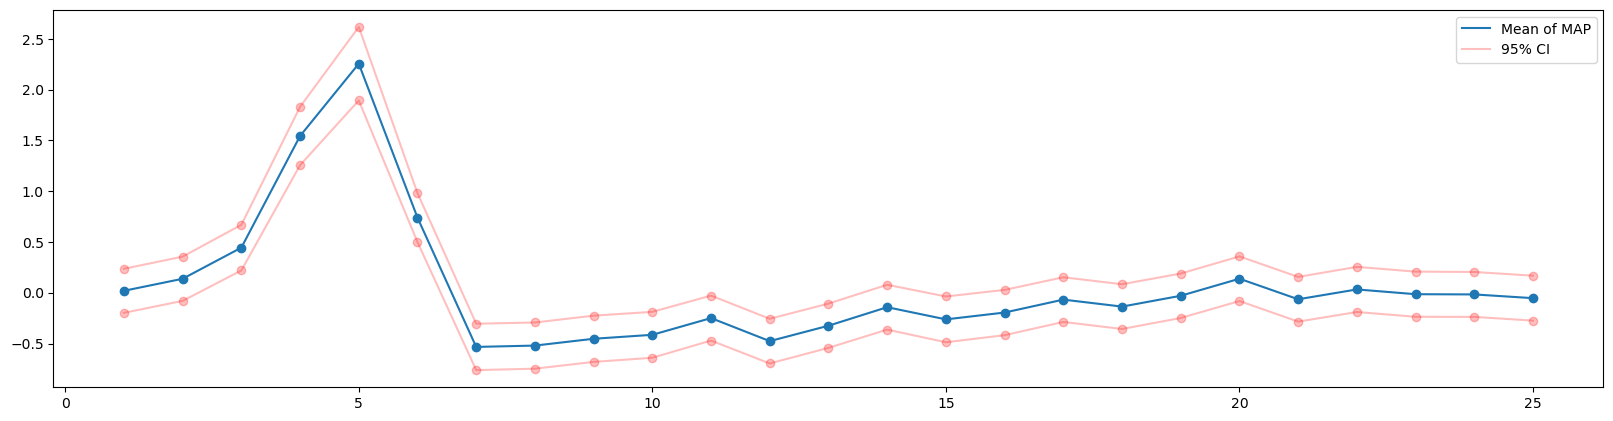

In [13]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 100
plt.clf()
upr, lwr = [], []
for i in range(1, 26):
    x_ = np.zeros(len(w_map)); x_[i] = 1 # for marginalizing
    marginal_cov = x_.T.dot(cov_wmap).dot(x_) # marginal covariance
    upr.append(w_map[i] + np.sqrt(marginal_cov) * 2)
    lwr.append(w_map[i] - np.sqrt(marginal_cov) * 2)
plt.plot(range(1, 26), w_map[1:], label = 'Mean of MAP')
plt.scatter(range(1, 26), w_map[1:])
plt.plot(range(1, 26), lwr, color='red', alpha=.25, label = '95% CI')
plt.scatter(range(1, 26), lwr, color='red', alpha=.25)
plt.plot(range(1, 26), upr, color='red', alpha=.25)
plt.scatter(range(1, 26), upr, color='red', alpha=.25)
plt.legend()
plt.plot()

## Problem 7 [Short Answer]: Interpret your results

Here, the neurons are cells from the retina, which are responsive to light. The stimulus at time bin $n$ is either -0.5 or +0.5 depending on whether a light was off or on, respectively, at that time. What do these weights tell you about the relationship between the stimulus and the spike counts? 

Judging by the apparent spike in between $\sim n- 2$ and $\sim n - 6$, it seems that these lagged times -- in particular, the $n-5$ time index, is particularly important here. A positive stimulus for this lag will result in a \textit{larger} value for $w^tx_i$ (as $w_5$ is positive), which in turn will result in a larger $\lambda = \exp(w^tx_i)$ and a greater mean and variance underlying the predicted Poisson. In contrast, a negative stimulus for this lag will result in a \textit{smaller} value for $w^tx_i$, and thus a smaller mean and variance underlying the predicted value. In this way, we see how a positive stimulus may affect the modeled spike count. 

---

## Problem 8: Approximate the posterior predictive distribution of the rates

Draw many samples $w^{(s)}$ from the Laplace approximation of the posterior $p(w \mid \{x_n, y_n\})$.  Use those samples to approximate the posterior predictive distribution on the **test** dataset,
\begin{align}
p(y_{n'}=k \mid x_{n'}, \{x_n, y_n\}_{n=1}^N) &= 
\int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}

Visualize the posterior predictive distribution as an $K \times N_{\mathsf{test}}$ array where row corresponds to possible spike counts $k\in \{0,\ldots, K\}$. You can set $K=5$ for this problem. **Only show the first 100 columns (time bins), otherwise it's hard to see changes in the rate.**

Overlay the actual spike counts for the test dataset. 

In [14]:
N=100 # number of test examples to show
K=5
S=10000

# retrieve the test data
y_test = df['y_test'].values
x_test = construct_design(df['stim_test'].values, padlength=25)

w_samp = multivariate_normal(w_map, cov_wmap).rvs(S, random_state=2020).T
lambda_hat = np.exp(x_test.dot(w_samp))
lambda_hat.shape
yhat = np.vstack([
    poisson(mu=lambda_hat[i, :]).rvs(S) for i in range(lambda_hat.shape[0])
])

yhat

array([[2, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 2, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

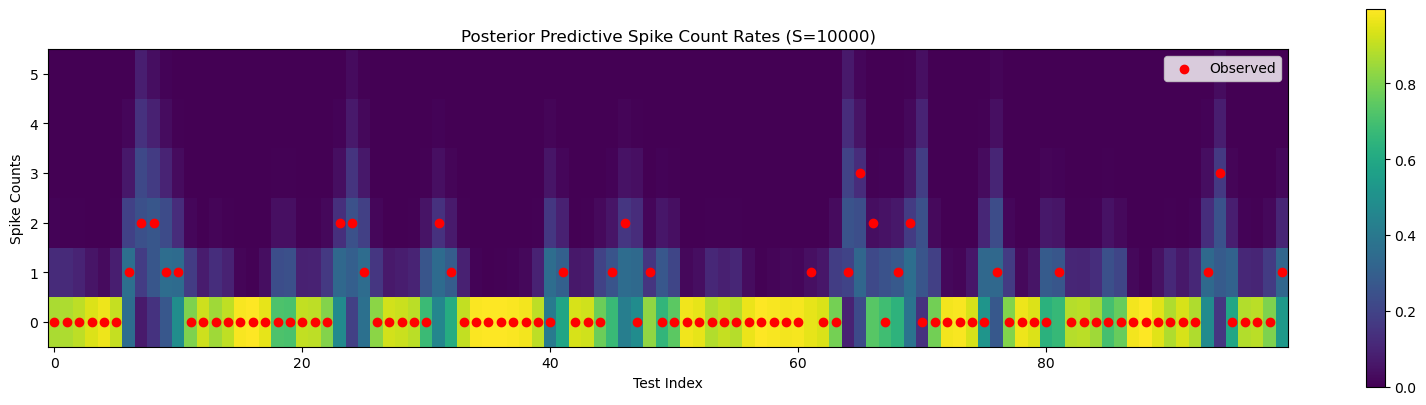

In [15]:
x_test_plt, yhat_plt, lambda_hat_plt = x_test[0:N, :], yhat[0:N, :], lambda_hat[0:N, :]
kmat = np.zeros((N, K+1))
for i in range(N):
    for k in range(K+1):
        kmat[i, k] = np.sum(yhat_plt[i, :] == k)/S
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 100
plt.clf()
plt.imshow(kmat.T, origin='lower', aspect=4)
plt.colorbar()
plt.scatter(range(N), y_test[0:N], color = 'red', label='Observed')
plt.xlabel('Test Index')
plt.title('Posterior Predictive Spike Count Rates (S=10000)')
plt.ylabel('Spike Counts')
plt.legend()
plt.show()

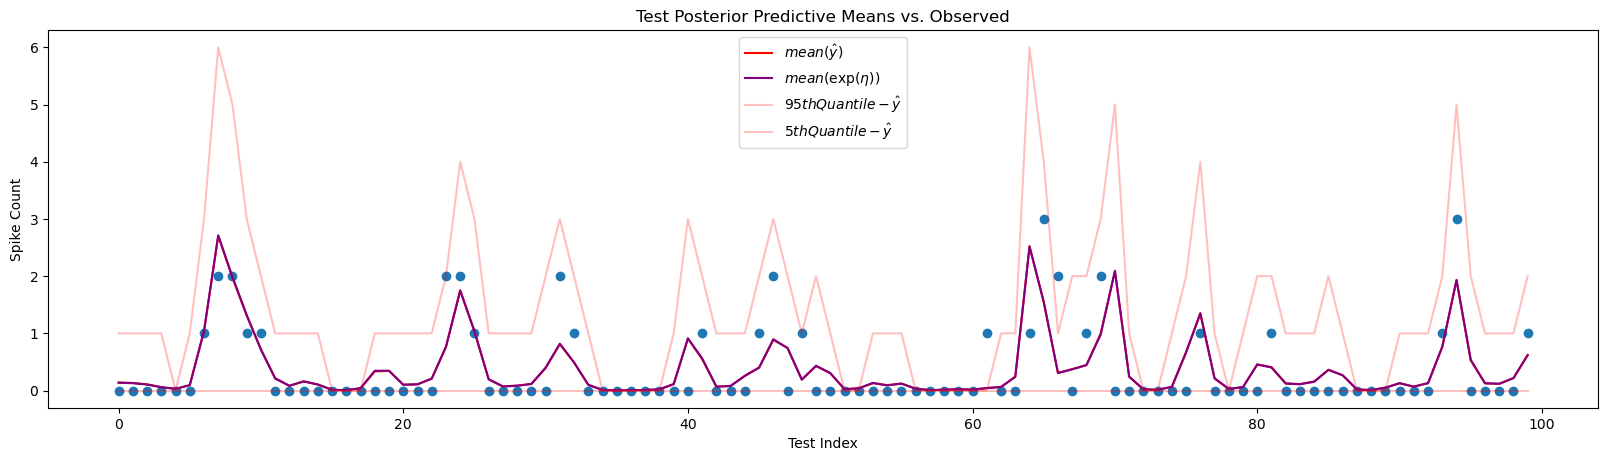

In [16]:
plt.clf()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 100
plt.scatter(range(N), y_test[0:N])
plt.plot(range(N), yhat_plt.mean(axis=1), label='$mean(\hat{y})$', color='red')
plt.plot(range(N), lambda_hat_plt.mean(axis=1), label='$mean(\exp(\eta))$', color='purple')
plt.plot(range(N), [np.quantile(yhat_plt[i, :], .95) for i in range(N)], 
         label='$95th Quantile - \hat{y}$', color='red', alpha=.25)
plt.plot(range(N), [np.quantile(yhat_plt[i, :], .05) for i in range(N)], 
         label='$5th Quantile - \hat{y}$', color='red', alpha=.25)
plt.legend()
plt.xlabel('Test Index')
plt.ylabel('Spike Count')
plt.title('Test Posterior Predictive Means vs. Observed')
plt.show()

## Problem 9: Compute the log predictive density

Simulate from the posterior distribution to compute a Monte Carlo approximation to what the book calls the _log pointwise predictive density_ (Eq. 7.4). 
\begin{align}
\sum_{n'=1}^{N_{\mathsf{test}}} \log p(y_{n'} \mid x_{n'}, \{x_n, y_n\}_{n=1}^N ) 
&= 
\sum_{n'=1}^{N_{\mathsf{test}}} \log \int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \sum_{n'=1}^{N_{\mathsf{test}}} \log \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N) \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}
Use $S=1000$ Monte Carlo samples and **print your result**.

_Note_: The book recommends a more fully Bayesian approach in which they compute the log pointwise predictive density for one data point at a time, using the remainder to compute the posterior distribution on the weights. For simplicity, we will stick with a single training and test split, as given in the dataset above.

In [17]:
S = 1000
w_samp = multivariate_normal(w_map, cov_wmap).rvs(S, random_state=2020).T
lambda_hats = x_test.dot(w_samp)
result = 0
for i in range(lambda_hats.shape[0]):
    y_ = np.ones(lambda_hats.shape[1]) * y_test[i]
    p_y = poisson.pmf(y_, np.exp(lambda_hats[i, ]))
    avg_p_y = np.mean(p_y)
    result += np.log(avg_p_y)
result

-533.2948841430846